# 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/dp
route = '/content/drive/MyDrive/dp/'
!ls

/content/drive/MyDrive/dp
create_COVIDxUS.ipynb  labels	model.png    README.md
data		       LICENSE	__pycache__  utils


In [3]:
import cv2 # for capturing videos
import math # for mathematical operations
%matplotlib inline
import pandas as pd
import numpy as np
import os
import random 

from progressbar import ProgressBar
from sklearn.metrics import accuracy_score
! pip install -q tensorflow-model-optimization
from tensorflow_model_optimization.sparsity import keras as sparsity
from keras.callbacks import ModelCheckpoint

import time
import matplotlib.pyplot as plt
import glob

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, ConvLSTM2D, BatchNormalization, Conv3D, MaxPooling3D
from keras.layers import TimeDistributed, GRU, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras import Model

import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow_model_optimization as tfmot
import tempfile
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard

     |████████████████████████████████| 213 kB 4.2 MB/s 


# 2. Loading DataSet

In [4]:
X_train=np.load('data/X_train_save_0.npy')
X_val = np.load('data/X_val_save_0.npy')
y_train = np.load("data/y_train_save_0.npy")
y_val = np.load("data/y_val_save_0.npy")

In [5]:
#max = X_train.max()
#X_train = X_train/max
#X_val = X_val/max
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

print("X_train size : {}".format(X_train.shape))
print("y_train size : {}".format(y_train.shape))
print("X_val size : {}".format(X_val.shape))
print("y_val size : {}".format(y_val.shape))

X_train size : (159, 14, 224, 224, 3)
y_train size : (159, 3)
X_val size : (39, 14, 224, 224, 3)
y_val size : (39, 3)


# 3. Training ConvLSTM2D Model

In [ ]:
print("X_train size : {}".format(X_train.shape))
print("X_val size : {}".format(X_val.shape))
print("y_train size : {}".format(y_train.shape))
print("y_val size : {}".format(y_val.shape))

X_train size : (159, 14, 224, 224, 3)
X_val size : (39, 14, 224, 224, 3)
y_train size : (159, 3)
y_val size : (39, 3)


In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (14, 224, 224, 3)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(3, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 222, 222, 64)      154624    
                                                                 
 dropout (Dropout)           (None, 222, 222, 64)      0         
                                                                 
 flatten (Flatten)           (None, 3154176)           0         
                                                                 
 dense (Dense)               (None, 256)               807469312 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 807,624,707
Trainable params: 807,624,707


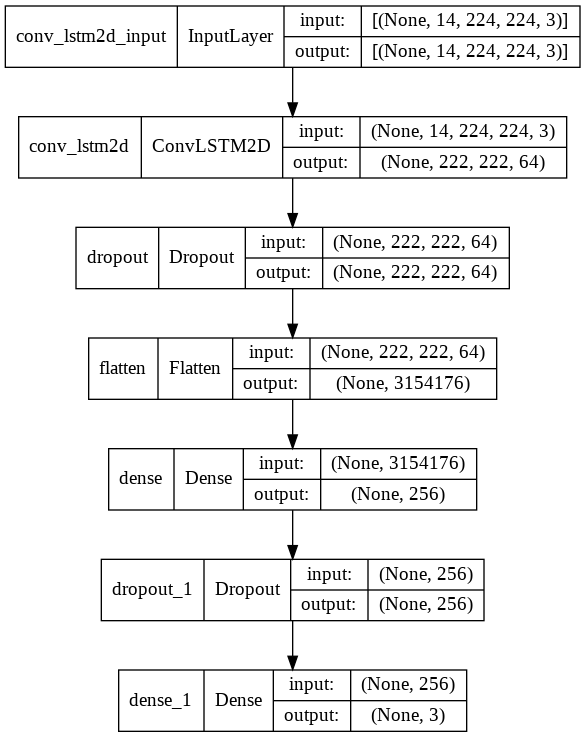

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
mcp_save = ModelCheckpoint('data/covid_us_weight.hdf5', save_best_only=True, monitor='val_loss', mode='min') # monitor='val_accuracy', mode='max')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
train_start = time.time()
result = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[mcp_save], batch_size=1)
train_end = time.time()

Epoch 1/15
159/159 [==============================] - 44s 211ms/step - loss: 0.9456 - accuracy: 0.5535 - val_loss: 0.9905 - val_accuracy: 0.4359
Epoch 2/15
159/159 [==============================] - 34s 216ms/step - loss: 0.7735 - accuracy: 0.6478 - val_loss: 0.8134 - val_accuracy: 0.5128
Epoch 3/15
159/159 [==============================] - 30s 188ms/step - loss: 0.7363 - accuracy: 0.6667 - val_loss: 1.0690 - val_accuracy: 0.5897
Epoch 4/15
159/159 [==============================] - 30s 188ms/step - loss: 0.6549 - accuracy: 0.7547 - val_loss: 0.9401 - val_accuracy: 0.5385
Epoch 5/15
159/159 [==============================] - 34s 213ms/step - loss: 0.6141 - accuracy: 0.7170 - val_loss: 0.8122 - val_accuracy: 0.5641
Epoch 6/15
159/159 [==============================] - 34s 216ms/step - loss: 0.5818 - accuracy: 0.7673 - val_loss: 0.6740 - val_accuracy: 0.6410
Epoch 7/15
159/159 [==============================] - 30s 189ms/step - loss: 0.4715 - accuracy: 0.7799 - val_loss: 0.8806 - val_ac

In [ ]:
print("It takes {:.2f} seconds to train".format((train_end - train_start)))
print("It takes {:.2f} minutes to train".format((train_end - train_start)/60))

It takes 505.25 seconds to train
It takes 8.42 minutes to train


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


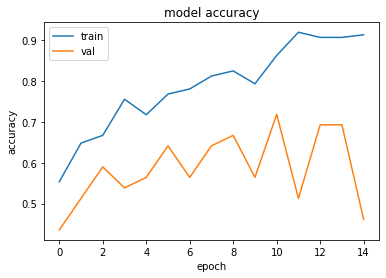

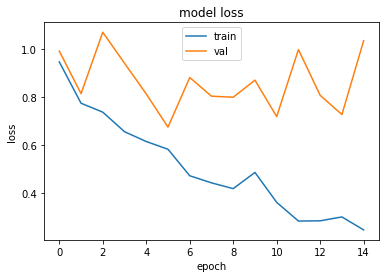

In [ ]:
print(result.history.keys())

# summarize history for accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper center')
plt.show()

In [ ]:
model.save("data/convlstm_model")

INFO:tensorflow:Assets written to: data/fcn_model/assets


# 4. Weight Pruning

In [ ]:
model=keras.models.load_model("data/covid_us_weight.hdf5")

In [ ]:
print("X_train size : {}".format(X_train.shape))
print("X_val size : {}".format(X_val.shape))
print("y_train size : {}".format(y_train.shape))
print("y_val size : {}".format(y_val.shape))

X_train size : (159, 14, 224, 224, 3)
X_val size : (39, 14, 224, 224, 3)
y_train size : (159, 3)
y_val size : (39, 3)


In [ ]:
batch_size=1
epochs = 10
end_step = np.ceil(1.0 * X_train.shape[0] / batch_size).astype(np.int32) * epochs

new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.25,
                                                   final_sparsity=0.5,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

In [ ]:
def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **new_pruning_params)
  return layer
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 222, 222, 64)      154624    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 64)      0         
                                                                 
 flatten (Flatten)           (None, 788544)            0         
                                                                 
 prune_low_magnitude_dense (  (None, 256)              403734786 
 PruneLowMagnitude)                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]


In [ ]:
train_start = time.time()
result = model_for_pruning.fit(X_train, y_train, batch_size=1, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)
train_end = time.time()

Epoch 1/10
159/159 [==============================] - 40s 222ms/step - loss: 6.4618 - accuracy: 0.5031 - val_loss: 3.2669 - val_accuracy: 0.4872
Epoch 2/10
159/159 [==============================] - 37s 235ms/step - loss: 1.8626 - accuracy: 0.6415 - val_loss: 1.4815 - val_accuracy: 0.5128
Epoch 3/10
159/159 [==============================] - 35s 218ms/step - loss: 1.0070 - accuracy: 0.7736 - val_loss: 1.3481 - val_accuracy: 0.5641
Epoch 4/10
159/159 [==============================] - 37s 235ms/step - loss: 1.7169 - accuracy: 0.7233 - val_loss: 1.2386 - val_accuracy: 0.5385
Epoch 5/10
159/159 [==============================] - 35s 219ms/step - loss: 0.6741 - accuracy: 0.8050 - val_loss: 1.0028 - val_accuracy: 0.5897
Epoch 6/10
159/159 [==============================] - 37s 235ms/step - loss: 0.3457 - accuracy: 0.8931 - val_loss: 0.7364 - val_accuracy: 0.7179
Epoch 7/10
159/159 [==============================] - 37s 235ms/step - loss: 0.5154 - accuracy: 0.8931 - val_loss: 1.0370 - val_ac

In [ ]:
print("It takes {:.2f} seconds to train".format((train_end - train_start)))
print("It takes {:.2f} minutes to train".format((train_end - train_start)/60))

It takes 370.97 seconds to train
It takes 6.18 minutes to train


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


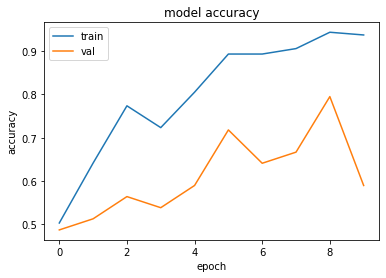

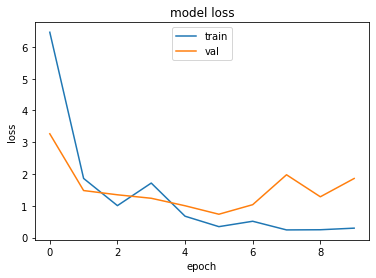

In [ ]:
print(result.history.keys())

# summarize history for accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper center')
plt.show()

In [ ]:
exportModel = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
exportModel.save("data/pruned_model.hd5f")

INFO:tensorflow:Assets written to: data/pruned_model2/assets


# 5. Knowledge Distillation (X)


In [ ]:
class Distiller(keras.Model):

  def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
  def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
student_loss_fn: Loss function of difference between student
                predictions and ground-truth
distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn=student_loss_fn
        self.distillation_loss_fn= distillation_loss_fn
        self.temperature= temperature
        self.alpha= alpha
        
  def train_step(self, data):
        x,y=data
        
        # Forward pass of teacher
        teacher_prediction=self.teacher(x, training=False)
        print("Tecaher prediction   ...", teacher_prediction)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predcition= self.student(x, training=True)
            # Compute losses
            student_loss= self.student_loss_fn(y, student_predcition)
            
            distillation_loss=self.distillation_loss_fn(
            tf.nn.softmax(teacher_prediction/self.temperature, axis=1),
            tf.nn.softmax(student_predcition/self.temperature, axis=1)
            )
            loss= self.alpha* student_loss + (1-self.alpha)* distillation_loss
            print("Loss in distiller :",loss)
            # Compute gradients
            trainable_vars= self.student.trainable_variables
            gradients=tape.gradient(loss, trainable_vars)
            gradients = [gradient * (self.temperature ** 2) for gradient in gradients]
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Update the metrics configured in `compile()`
            self.compiled_metrics.update_state(y, student_predcition)
            
            # Return a dict of performance
            results={ m.name: m.result()  for m in self.metrics}
            results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
            print("Train...", results)
            return results
  def test_step(self, data):
        # Unpack the data
        x, y = data
        
        ## Compute predictions
        y_prediction= self.student(x, training=False)
        
        # calculate the loss
        student_loss= self.student_loss_fn(y, y_prediction)
        
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        
        # Return a dict of performance
        results ={m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        print("Test...", results)
        return results

In [ ]:
org_model=keras.models.load_model("data/covid_us_weight.hdf5")
student_model = Sequential()
student_model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (14, 224, 224, 3)))
student_model.add(MaxPooling2D())
student_model.add(Dropout(0.4))
student_model.add(Flatten())
student_model.add(Dense(256, activation="relu"))
student_model.add(Dropout(0.4))
student_model.add(Dense(3, activation = "softmax"))

In [ ]:
student = student_model
teacher = org_model

distiller= Distiller(student=student, teacher=teacher)

In [ ]:
print("X_train size : {}".format(X_train.shape))
print("X_val size : {}".format(X_val.shape))
print("y_train size : {}".format(y_train.shape))
print("y_val size : {}".format(y_val.shape))

X_train size : (219, 14, 224, 224, 3)
X_val size : (42, 14, 224, 224, 3)
y_train size : (219, 3)
y_val size : (42, 3)


In [ ]:
y_temp=[]
y_train2=y_train.to_numpy()
for i in range(y_train2.shape[0]):
  y_temp.append(np.argmax(y_train2[i]))
y_train2=np.array(y_temp)
y_train2.shape

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2,
       1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 1, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2,
       1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0,
       0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2])

In [ ]:
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=1,
)

# Distill teacher to student
distiller.fit(X_train, y_train2, epochs=4)

Epoch 1/4
Tecaher prediction   ... Tensor("sequential/dense_1/Softmax:0", shape=(None, 3), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
Tecaher prediction   ... Tensor("sequential/dense_1/Softmax:0", shape=(None, 3), dtype=float32)
Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}


ResourceExhaustedError: ignored

In [ ]:
#compile distiller
distiller.compile(optimizer=keras.optimizers.Adam(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 distillation_loss_fn=keras.losses.KLDivergence(),
                 alpha=0.3,
                 temperature=7)

# 6. Post-Training Quantiazion

In [ ]:
org_model=keras.models.load_model("data/covid_us_weight.hdf5")
pruned_model=keras.models.load_model("data/pruned_model.hdf5")

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
_, org_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(org_model, org_keras_file, include_optimizer=False)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(pruned_model, pruned_keras_file, include_optimizer=False)

In [ ]:
lite_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(lite_model)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpkgbuegqd/assets


Saved pruned TFLite model to: /tmp/tmpldne1ixb.tflite


In [ ]:
print("Size of gzipped original Keras model: %.2f bytes" % (get_gzipped_model_size(org_keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped quantized tflite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped original Keras model: 748051518.00 bytes
Size of gzipped pruned Keras model: 595833134.00 bytes
Size of gzipped quantized tflite model: 591767602.00 bytes


# ※Accuracy Test

In [7]:
test_dataset = pd.read_csv("data/test_dataset.csv")

In [9]:
model=keras.models.load_model("data/pruned_model.hdf5")

In [10]:
# create images_14frames_test folders, if they do not exist
if not os.path.exists('data/images_captured_test'):
    os.makedirs('data/images_captured_test')

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
	  (im_height, im_width, channels)).astype(np.uint8)
   
def featuring_space(frame_count):
  if frame_count<=28:
    return 1
  elif frame_count<=56:
    return 2
  elif frame_count<=84:
    return 3
  elif frame_count<=112:
    return 4
  else : return 5

In [16]:
files = glob.glob('data/images_captured_test/*')
for f in files:
    os.remove(f)

In [13]:
frames=14
channels=3
rows=224
columns=224
height=224
width=224
classes=3

In [14]:
test_dataset

,filename
0,132_litfl_pneumonia_prc_convex_clean.avi
1,218_clarius_covid_prc_convex_clean.avi
2,220_clarius_covid_prc_convex_clean.avi
3,151_litfl_pneumonia_prc_convex_clean.avi
4,175_uf_normal_prc_convex_clean.avi
5,7_butterfly_covid_prc_convex_clean.avi
6,45_litfl_pneumonia_prc_convex_clean.avi
7,93_butterfly_covid_prc_convex_clean.avi
8,46_litfl_pneumonia_prc_convex_clean.avi
9,72_pocusatlas_pneumonia_prc_convex_clean.avi


In [17]:
test_label=[]
actual=[]
predict=[]
for i in range(test_dataset.shape[0]):

    prediction_images = []
    each_pred = [0, 0, 0]
    count = 0
    current = 0
    videoFile = test_dataset['filename'][i]
    disease = videoFile.split('_')[2]
    if disease == 'covid' :
      disease_num = 0
    elif disease == 'pneumonia' :
      disease_num = 1
    else : disease_num = 2
    actual.append(disease_num)
    cap = cv2.VideoCapture('data/video/clean_copy2/' + videoFile) # capturing the video from the given path
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    space = featuring_space(frame_count)
    capture_epoch = math.floor( frame_count / (14*space) )
    capture_num = capture_epoch*14

    while(cap.isOpened()):
      if(count!=0 and count%14==0 and len(prediction_images)!=0):
        prediction_images=np.array(prediction_images)
        prediction = model.predict(prediction_images.reshape(-1,14,224,224,3))
        predict_temp =np.argmax(prediction,axis=1)
        each_pred[predict_temp[0]]=each_pred[predict_temp[0]]+1
        prediction_images=[]
      if(count==capture_num):
        break
      cap.get(1)
      ret, frame = cap.read()
      if (ret != True):
        break
      if current%space==0 :
        filename = 'data/images_captured_test/' + videoFile + "_frame_%d.jpg" % count; count += 1
        cv2.imwrite(filename, frame)
        img = image.load_img(filename, target_size=(height,width,channels))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        if(count%14==0):
          test_label.append(disease_num)
      current=current+1
    cap.release()
    predict.append(np.argmax(each_pred))

len(os.listdir('data/images_captured_test/'))

812

In [18]:
print("Actual  Predict")
count=0
for i in range(len(actual)) :
  if count == len(actual):
    count=0
    print("\nActual  Predict")
  print(actual[i],"       ",predict[i])
  count=count+1

Actual  Predict
1         1
0         1
0         0
1         0
2         0
0         0
1         1
0         0
1         1
1         1
2         1
0         0
2         2
2         0
0         0
2         2
0         0
0         0
1         1
2         2
0         0
1         1
2         0
0         0
0         0
0         0
0         0
0         0
1         1
1         1
0         1
1         1
2         0
2         2
2         0
0         0


In [19]:
# checking the accuracy of the predicted tags
accuracy = accuracy_score(predict, actual)
print('accuracy :', accuracy*100, '%')

accuracy : 75.0 %


<metrics of covid class>

 TP (true positive) : 14 
 FN (false negative) : 2 
 FP (false positive) : 6 
 TN (true negative) : 14 

 Accuracy (=(TP+TN)/(TP+FN+FP+TN)) : 0.7778
 Error_rate (=(FP+FN)/(TP+FN+FP+TN)) : 0.2222
 Precision (=TP/(TP+FP)) : 0.7000
 Recall (=TP/(TP+FN)) : 0.8750
 Specificity (=TN/(FP+TN)) : 0.7000
 F1_score (=2*(Recall*Precision)/(Recall+Precision)) : 0.7778


<metrics of pneumonia class>

 TP (true positive) : 9 
 FN (false negative) : 1 
 FP (false positive) : 3 
 TN (true negative) : 23 

 Accuracy (=(TP+TN)/(TP+FN+FP+TN)) : 0.8889
 Error_rate (=(FP+FN)/(TP+FN+FP+TN)) : 0.1111
 Precision (=TP/(TP+FP)) : 0.7500
 Recall (=TP/(TP+FN)) : 0.9000
 Specificity (=TN/(FP+TN)) : 0.8846
 F1_score (=2*(Recall*Precision)/(Recall+Precision)) : 0.8182


<metrics of normal class>

 TP (true positive) : 4 
 FN (false negative) : 6 
 FP (false positive) : 0 
 TN (true negative) : 26 

 Accuracy (=(TP+TN)/(TP+FN+FP+TN)) : 0.8333
 Error_rate (=(FP+FN)/(TP+FN+FP+TN)) : 0.1667
 Pre

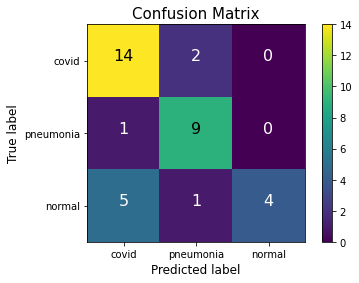

In [20]:
con_mat = tf.math.confusion_matrix(labels=actual, predictions=predict, num_classes=3).numpy()

print("<metrics of covid class>\n")

TP = con_mat[0][0]                                                               # 관심 범주(positive)를 정확하게 분류
FN = con_mat[0][1] + con_mat[0][2]                                               # 관심 범주를 아닌 것으로 잘못 분류
FP = con_mat[1][0] + con_mat[2][0]                                               # 관심 범주가 아닌 것을 관심 범주로 잘못 분류
TN = con_mat[1][1] + con_mat[1][2] + con_mat[2][1] + con_mat[2][2]               # 관심 범주가 아닌 것(negative)을 정확하게 분류
print(' TP (true positive) :', TP, '\n', 
      'FN (false negative) :', FN, '\n', 
      'FP (false positive) :', FP, '\n', 
      'TN (true negative) :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN)                                                 # 정확도는 전체 중 모델이 바르게 분류한 비율
print(' Accuracy (=(TP+TN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Accuracy))
Error_rate = (FP+FN)/(TP+FN+FP+TN)                                               # 정확도의 반대
print(' Error_rate (=(FP+FN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Error_rate))
Precision = TP/(TP+FP)                                                           # 정밀도는 모델이 positive라 분류한 것 중 실제값이 positive인 비율
print(' Precision (=TP/(TP+FP)) :', '{:.4f}'.format(Precision))
Recall = TP/(TP+FN)                                                              # 재현도는 실제값이 positive인 것 중 모델이 positive라 분류한 비율 (Sensitivity)
print(' Recall (=TP/(TP+FN)) :', '{:.4f}'.format(Recall))
Specificity = TN/(FP+TN)                                                         # 특이도는 실제값이 negative인 것 중 모델이 negative라 분류한 비율
print(' Specificity (=TN/(FP+TN)) :', '{:.4f}'.format(Specificity))
F1_score = 2*(Recall*Precision)/(Recall+Precision)                               # 보통 불균형 분류 문제에서 평가 척도로 사용
print(' F1_score (=2*(Recall*Precision)/(Recall+Precision)) :', '{:.4f}'.format(F1_score))
print()
print()

print("<metrics of pneumonia class>\n")

TP = con_mat[1][1]                                                               # 관심 범주(positive)를 정확하게 분류
FN = con_mat[1][0] + con_mat[1][2]                                               # 관심 범주를 아닌 것으로 잘못 분류
FP = con_mat[0][1] + con_mat[2][1]                                               # 관심 범주가 아닌 것을 관심 범주로 잘못 분류
TN = con_mat[0][0] + con_mat[0][2] + con_mat[2][0] + con_mat[2][2]               # 관심 범주가 아닌 것(negative)을 정확하게 분류
print(' TP (true positive) :', TP, '\n', 
      'FN (false negative) :', FN, '\n', 
      'FP (false positive) :', FP, '\n', 
      'TN (true negative) :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN)                                                 # 정확도는 전체 중 모델이 바르게 분류한 비율
print(' Accuracy (=(TP+TN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Accuracy))
Error_rate = (FP+FN)/(TP+FN+FP+TN)                                               # 정확도의 반대
print(' Error_rate (=(FP+FN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Error_rate))
Precision = TP/(TP+FP)                                                           # 정밀도는 모델이 positive라 분류한 것 중 실제값이 positive인 비율
print(' Precision (=TP/(TP+FP)) :', '{:.4f}'.format(Precision))
Recall = TP/(TP+FN)                                                              # 재현도는 실제값이 positive인 것 중 모델이 positive라 분류한 비율 (Sensitivity)
print(' Recall (=TP/(TP+FN)) :', '{:.4f}'.format(Recall))
Specificity = TN/(FP+TN)                                                         # 특이도는 실제값이 negative인 것 중 모델이 negative라 분류한 비율
print(' Specificity (=TN/(FP+TN)) :', '{:.4f}'.format(Specificity))
F1_score = 2*(Recall*Precision)/(Recall+Precision)                               # 보통 불균형 분류 문제에서 평가 척도로 사용
print(' F1_score (=2*(Recall*Precision)/(Recall+Precision)) :', '{:.4f}'.format(F1_score))
print()
print()

print("<metrics of normal class>\n")

TP = con_mat[2][2]                                                               # 관심 범주(positive)를 정확하게 분류
FN = con_mat[2][0] + con_mat[2][1]                                               # 관심 범주를 아닌 것으로 잘못 분류
FP = con_mat[0][2] + con_mat[1][2]                                               # 관심 범주가 아닌 것을 관심 범주로 잘못 분류
TN = con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1]               # 관심 범주가 아닌 것(negative)을 정확하게 분류
print(' TP (true positive) :', TP, '\n', 
      'FN (false negative) :', FN, '\n', 
      'FP (false positive) :', FP, '\n', 
      'TN (true negative) :', TN, '\n')

Accuracy = (TP+TN)/(TP+FN+FP+TN)                                                 # 정확도는 전체 중 모델이 바르게 분류한 비율
print(' Accuracy (=(TP+TN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Accuracy))
Error_rate = (FP+FN)/(TP+FN+FP+TN)                                               # 정확도의 반대
print(' Error_rate (=(FP+FN)/(TP+FN+FP+TN)) :', '{:.4f}'.format(Error_rate))
Precision = TP/(TP+FP)                                                           # 정밀도는 모델이 positive라 분류한 것 중 실제값이 positive인 비율
print(' Precision (=TP/(TP+FP)) :', '{:.4f}'.format(Precision))
Recall = TP/(TP+FN)                                                              # 재현도는 실제값이 positive인 것 중 모델이 positive라 분류한 비율 (Sensitivity)
print(' Recall (=TP/(TP+FN)) :', '{:.4f}'.format(Recall))
Specificity = TN/(FP+TN)                                                         # 특이도는 실제값이 negative인 것 중 모델이 negative라 분류한 비율
print(' Specificity (=TN/(FP+TN)) :', '{:.4f}'.format(Specificity))
F1_score = 2*(Recall*Precision)/(Recall+Precision)                               # 보통 불균형 분류 문제에서 평가 척도로 사용
print(' F1_score (=2*(Recall*Precision)/(Recall+Precision)) :', '{:.4f}'.format(F1_score))
print()

plt.imshow(con_mat)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
label = ["covid", "pneumonia", "normal"]
tick_marks = np.arange(len(label)) 
plt.xticks(tick_marks, label)
plt.yticks(tick_marks, label)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
# name = [['TP','FN'], ['FP', 'TN']]
thresh = con_mat.max() / 2.
for i in range(3):
     for j in range(3):
        plt.text(j, i, str(con_mat[i, j]), # str(name[i][j])+" = "+
                 horizontalalignment="center",
                 color="white" if con_mat[i, j] < thresh else "black",
                 fontsize=16)
plt.show()

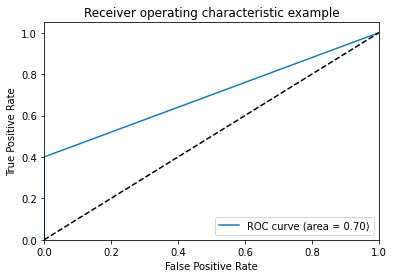

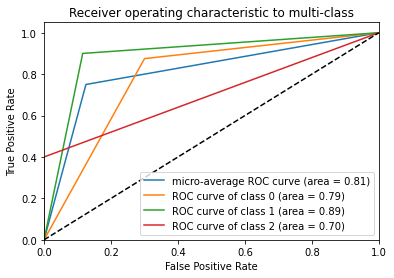

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PREDICTION_LIST_1 = label_binarize(predict, classes=[0, 1, 2])
ACTUAL_LIST_1 = label_binarize(actual, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ACTUAL_LIST_1[:, i], PREDICTION_LIST_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ACTUAL_LIST_1.ravel(), PREDICTION_LIST_1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()